In [127]:
import os
from glob import glob
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

In [128]:
risultati = [y for x in os.walk("final_joined_result/") for y in glob(os.path.join(x[0], '*.csv'))]
risultati[:5]

['final_joined_result/2d-20c-no0_y.zip CenterParTree2.csv',
 'final_joined_result/triangle2_y.zip-4_True_k kmeans+dt.csv',
 'final_joined_result/s-set2_y.zip PrincipalParTree.csv',
 'final_joined_result/cure-t1-2000n-2D_y.zip PrincipalParTree.csv',
 'final_joined_result/zelnik5_y.zip ImpurityParTree2.csv']

In [129]:
risultati_groupby_alg = dict()
risultati_groupby_dataset = dict()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("\\")[-1][:-4]
    
    if alg not in risultati_groupby_alg:
        risultati_groupby_alg[alg] = []
    if dataset not in risultati_groupby_dataset:
        risultati_groupby_dataset[dataset] = []
    
    risultati_groupby_alg[alg].append(filename)
    risultati_groupby_dataset[dataset].append(filename)

In [130]:
res_values_uns = ["time", "silhouette", "calinski_harabasz", "davies_bouldin"]
res_values_sup = ["r_score", "adj_rand", "mut_info_score", "adj_mutual_info_score", "norm_mutual_info_score",
                                 "homog_score", "complete_score", "v_msr_score", "fwlks_mallows_score"]
res_values_all = res_values_uns + res_values_sup

In [131]:
df = pd.DataFrame()
lista = []

datasets = set()
algorithms = set()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("/")[-1][:-4].replace(".zip", "").replace("-", "")
    
    skip = False
    for d in ["german_credit_y", "ionosphere_y", "home", "iris", "wdbc_y", "vehicle_y", "titanic_y", "wine"]:
        if d in dataset:
            skip = True
    if skip: continue
        
    
    datasets.add(dataset)
    algorithms.add(alg)
    
    lista.append(pd.read_csv(filename))
    
    lista[-1]["alg"] = alg
    if "wine" in dataset:
        lista[-1]["dataset"] = "wine"
    elif "home" in dataset:
        lista[-1]["dataset"] = "home"
    else:
        lista[-1]["dataset"] = dataset.split("_y")[0]+"_y"
    
df = pd.concat(lista)

df.columns

Index(['max_depth', 'max_nbr_clusters', 'min_samples_leaf',
       'min_samples_split', 'max_nbr_values', 'max_nbr_values_cat', 'bic_eps',
       'random_state', 'metric_con', 'metric_cat', 'time', 'silhouette',
       'calinski_harabasz', 'davies_bouldin', 'r_score', 'adj_rand',
       'mut_info_score', 'adj_mutual_info_score', 'norm_mutual_info_score',
       'homog_score', 'complete_score', 'v_msr_score', 'fwlks_mallows_score',
       'alg', 'dataset', 'n_clusters', 'labels_as_tree_leaves', 'init',
       'n_init', 'max_iter', 'tol', 'verbose', 'copy', 'algorithm',
       'criterion', 'splitter', 'min_weight_fraction_leaf', 'max_features',
       'max_leaf_nodes', 'min_impurity_decrease', 'class_weight', 'ccp_alpha',
       'n_components', 'oblique_splits', 'max_oblique_features',
       'criteria_clf', 'criteria_reg', 'number_clusters', 'bisecting_strategy',
       'min_nr_instances', 'min_y', 'min_rd', 'eps', 'min_samples', 'metric',
       'n_jobs', 'threshold', 'branching_factor

In [132]:
datasets

{'2d10c_y',
 '2d10c_y10_Tr',
 '2d10c_y12_Tr',
 '2d10c_y2_Tr',
 '2d10c_y4_Tr',
 '2d10c_y6_Tr',
 '2d10c_y8_Tr',
 '2d20cno0_y',
 '2d20cno0_y10_Tr',
 '2d20cno0_y12_Tr',
 '2d20cno0_y2_Tr',
 '2d20cno0_y4_Tr',
 '2d20cno0_y6_Tr',
 '2d20cno0_y8_Tr',
 '2d3cno123_y',
 '2d3cno123_y10_Tr',
 '2d3cno123_y12_Tr',
 '2d3cno123_y2_Tr',
 '2d3cno123_y4_Tr',
 '2d3cno123_y6_Tr',
 '2d3cno123_y8_Tr',
 '2d4c_y',
 '2d4c_y10_Tr',
 '2d4c_y12_Tr',
 '2d4c_y2_Tr',
 '2d4c_y4_Tr',
 '2d4c_y6_Tr',
 '2d4c_y8_Tr',
 '2d4cno9_y',
 '2d4cno9_y10_Tr',
 '2d4cno9_y12_Tr',
 '2d4cno9_y2_Tr',
 '2d4cno9_y4_Tr',
 '2d4cno9_y6_Tr',
 '2d4cno9_y8_Tr',
 '2dd31_y',
 '2dd31_y10_Tr',
 '2dd31_y12_Tr',
 '2dd31_y2_Tr',
 '2dd31_y4_Tr',
 '2dd31_y6_Tr',
 '2dd31_y8_Tr',
 'aggregation_y',
 'aggregation_y10_Tr',
 'aggregation_y12_Tr',
 'aggregation_y2_Tr',
 'aggregation_y4_Tr',
 'aggregation_y6_Tr',
 'aggregation_y8_Tr',
 'avila_y',
 'curet02000n2D_y',
 'curet02000n2D_y10_Tr',
 'curet02000n2D_y12_Tr',
 'curet02000n2D_y2_Tr',
 'curet02000n2D_y4_Tr',
 '

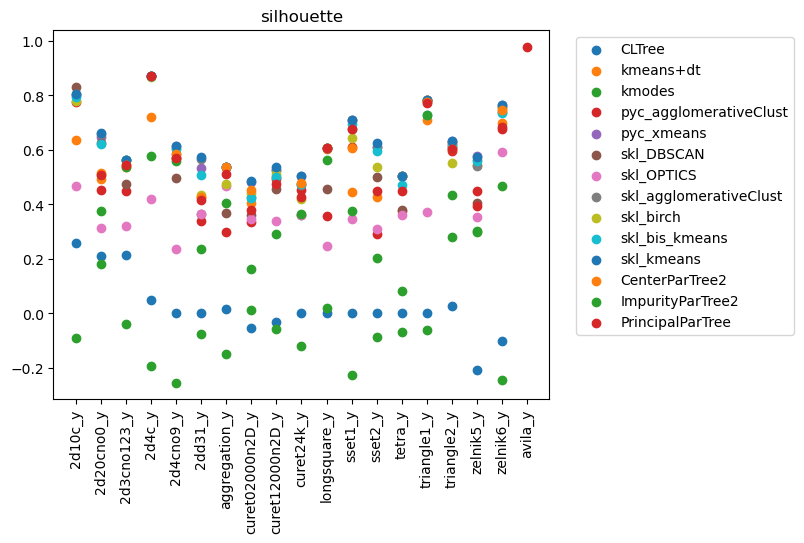

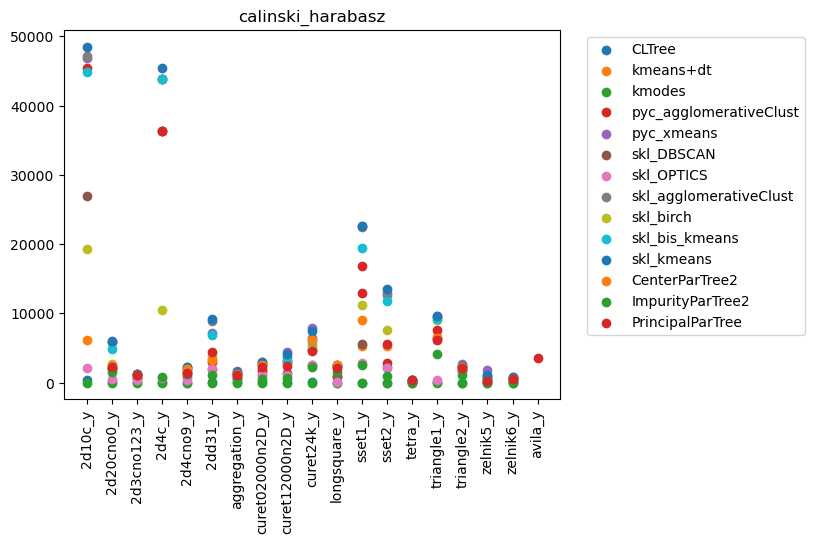

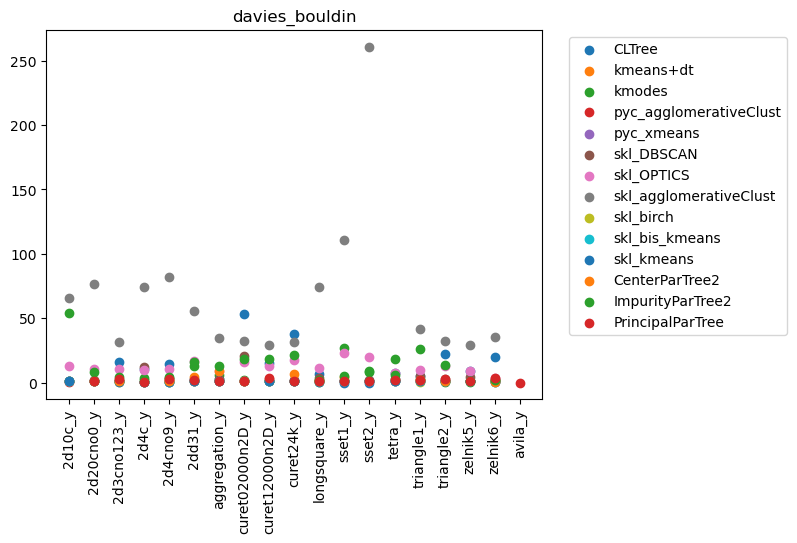

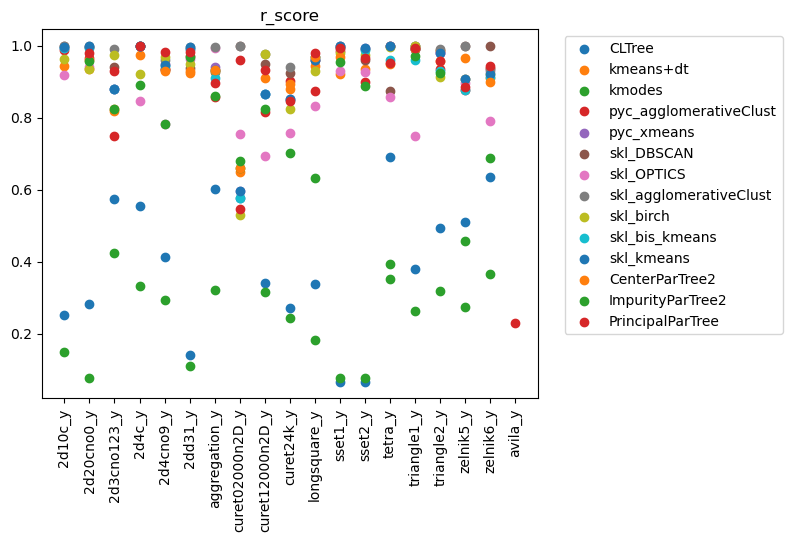

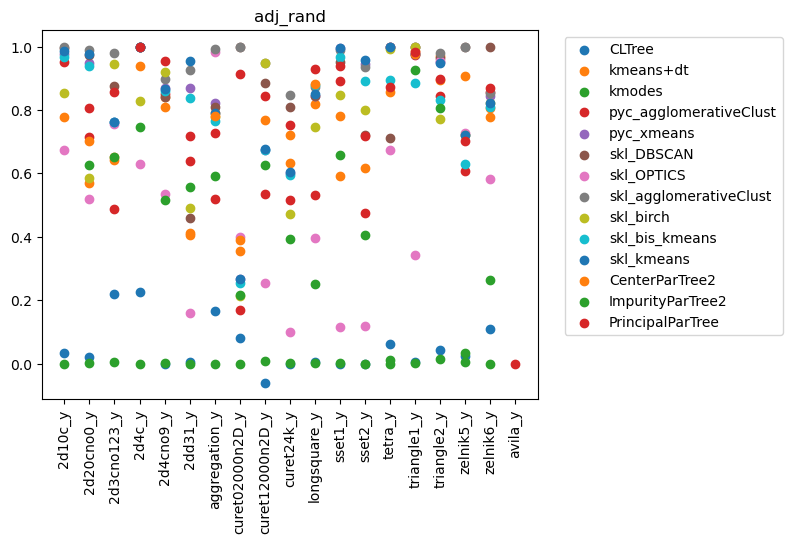

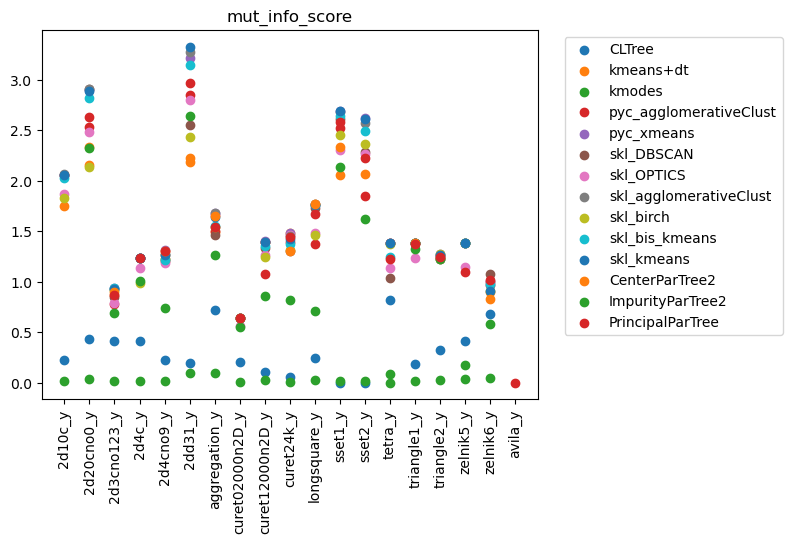

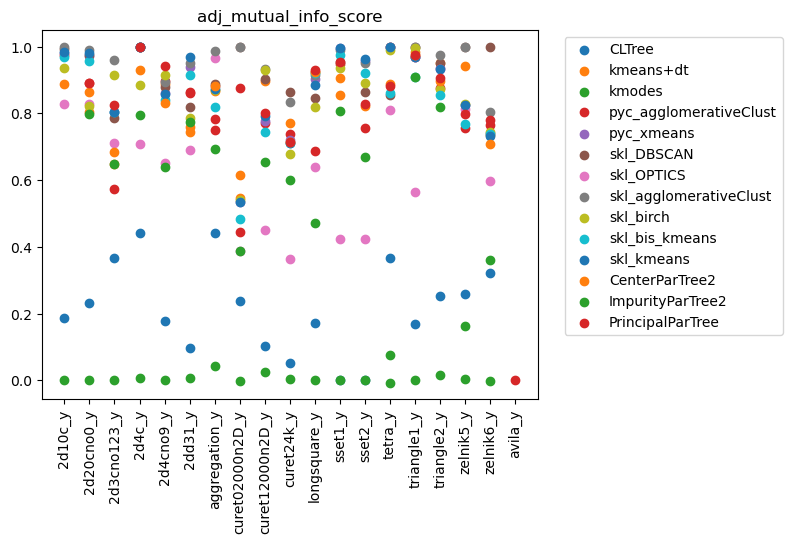

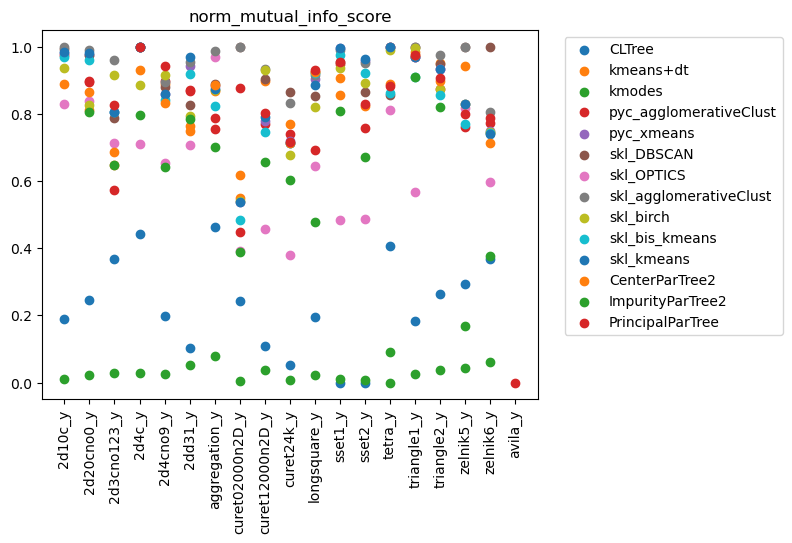

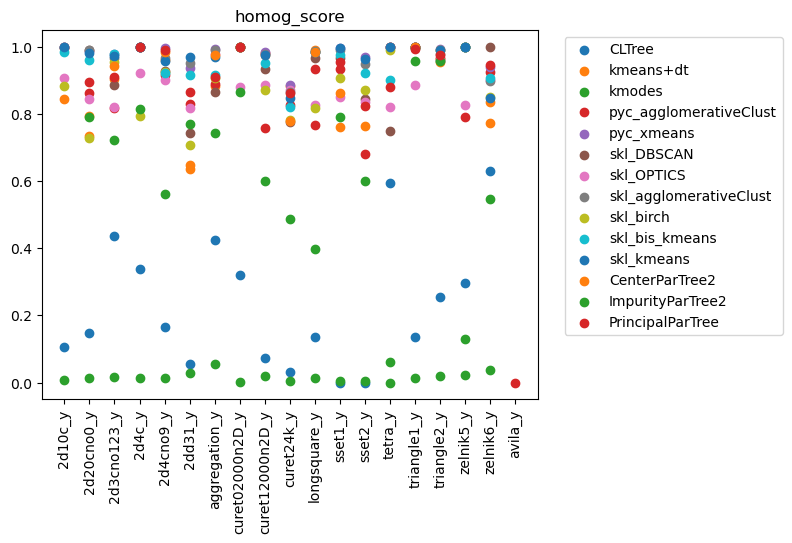

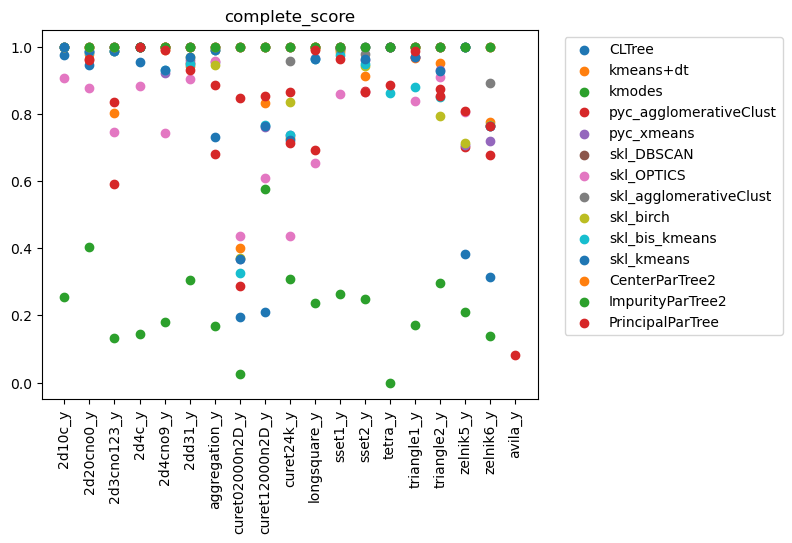

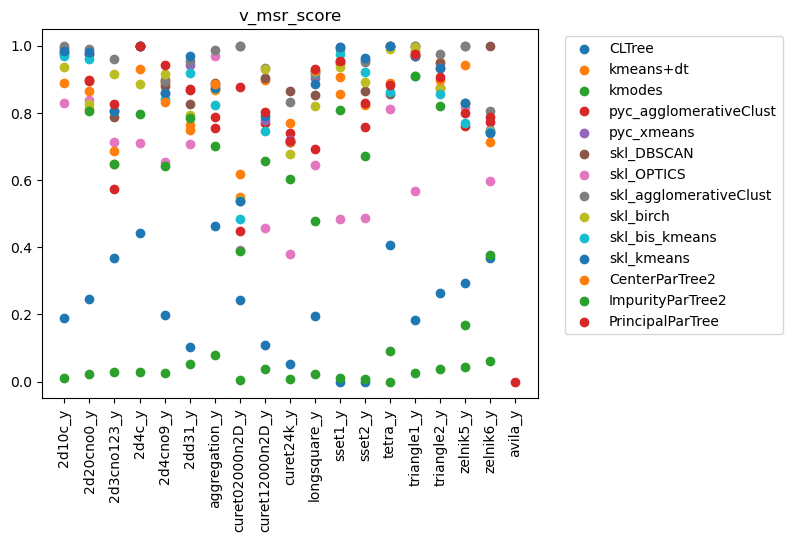

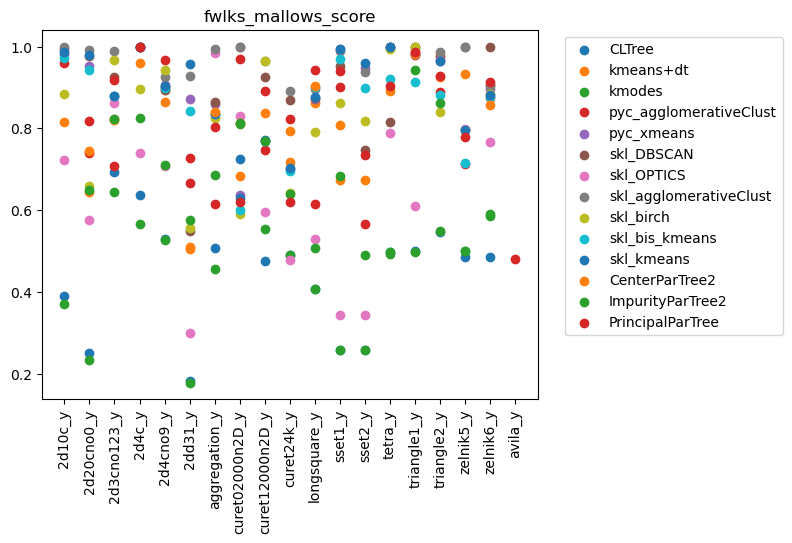

In [133]:
for col in res_values_all:
    if col == "time":
        continue

    df_plot = df.groupby(by=["dataset", "alg"])[[col, "time"]].max().reset_index()
    
    #df_plot = df_plot[df_plot.alg.isin(algoritmi_grafico)]

    for alg in df_plot.alg.unique():
        plt.scatter(df_plot[df_plot.alg == alg].dataset, 
                    df_plot[df_plot.alg == alg][col], 
                    label=alg, 
                    #s=df_plot[df_plot.alg == alg].time
                   )

    plt.title(col)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    plt.xticks(rotation=90)

    plt.show()

In [134]:
df.head()

,max_depth,max_nbr_clusters,min_samples_leaf,min_samples_split,max_nbr_values,max_nbr_values_cat,bic_eps,random_state,metric_con,metric_cat,...,eps,min_samples,metric,n_jobs,threshold,branching_factor,max_eps,amount_initial_centers,kmax,linkage
0,10.0,10.0,30.0,50.0,1000.0,100.0,0.0,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,10.0,30.0,50.0,1000.0,100.0,0.1,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,10.0,30.0,50.0,1000.0,100.0,0.2,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,10.0,30.0,50.0,1000.0,20.0,0.0,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,10.0,30.0,50.0,1000.0,20.0,0.1,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
df.sort_values(['dataset', 'alg', 'silhouette'], ascending=False).groupby(['dataset', 'alg']).nth(0)

max_depth  max_nbr_clusters  \
dataset   alg                                                   
2d10c_y   CLTree                        NaN               NaN   
          kmeans+dt                     NaN               NaN   
          kmodes                        NaN               NaN   
          pyc_agglomerativeClust        NaN               NaN   
          pyc_xmeans                    NaN               NaN   
...                                     ...               ...   
zelnik6_y skl_OPTICS                    NaN               NaN   
          skl_agglomerativeClust        NaN               NaN   
          skl_birch                     NaN               NaN   
          skl_bis_kmeans                NaN               NaN   
          skl_kmeans                    NaN               NaN   

                                  min_samples_leaf  min_samples_split  \
dataset   alg                                                           
2d10c_y   CLTree                               NaN                NaN   
          kmeans+dt                           50.0               30.0   
          kmodes                               NaN                NaN   
          pyc_agglomerativeClust               NaN                NaN   
          pyc_xmeans                           NaN                NaN   
...                                            ...                ...   
zelnik6_y skl_OPTICS                           NaN                NaN   
          skl_agglomerativeClust               NaN                NaN   
          skl_birch                            NaN                NaN   
          skl_bis_kmeans                       NaN                NaN   
          skl_kmeans                           NaN                NaN   

                                  max_nbr_values  max_nbr_values_cat  bic_eps  \
dataset   alg                                                                   
2d10c_y   CLTree                             NaN                 NaN      NaN   
          kmeans+dt                          NaN                 NaN      NaN   
          kmodes                             NaN                 NaN      NaN   
          pyc_agglomerativeClust             NaN                 NaN      NaN   
          pyc_xmeans                         NaN                 NaN      NaN   
...                                          ...                 ...      ...   
zelnik6_y skl_OPTICS                         NaN                 NaN      NaN   
          skl_agglomerativeClust             NaN                 NaN      NaN   
          skl_birch                          NaN                 NaN      NaN   
          skl_bis_kmeans                     NaN                 NaN      NaN   
          skl_kmeans                         NaN                 NaN      NaN   

                                  random_state metric_con metric_cat  ...  \
dataset   alg                                                         ...   
2d10c_y   CLTree                           NaN        NaN        NaN  ...   
          kmeans+dt                       42.0        NaN        NaN  ...   
          kmodes                          42.0        NaN        NaN  ...   
          pyc_agglomerativeClust           NaN        NaN        NaN  ...   
          pyc_xmeans                       NaN        NaN        NaN  ...   
...                                        ...        ...        ...  ...   
zelnik6_y skl_OPTICS                       NaN        NaN        NaN  ...   
          skl_agglomerativeClust           NaN        NaN        NaN  ...   
          skl_birch                        NaN        NaN        NaN  ...   
          skl_bis_kmeans                  42.0        NaN        NaN  ...   
          skl_kmeans                      42.0        NaN        NaN  ...   

                                  eps  min_samples       metric  n_jobs  \
dataset   alg                                                             
2d10c_y   CLTree                

In [136]:
df.groupby(['dataset', 'alg']).filter(lambda x: True)#.nth(100)  #[['dataset', 'alg', 'silhouette']]

,max_depth,max_nbr_clusters,min_samples_leaf,min_samples_split,max_nbr_values,max_nbr_values_cat,bic_eps,random_state,metric_con,metric_cat,...,eps,min_samples,metric,n_jobs,threshold,branching_factor,max_eps,amount_initial_centers,kmax,linkage
0,10.0,10.0,30.0,50.0,1000.0,100.0,0.0,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,10.0,30.0,50.0,1000.0,100.0,0.1,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,10.0,30.0,50.0,1000.0,100.0,0.2,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,10.0,30.0,50.0,1000.0,20.0,0.0,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,10.0,30.0,50.0,1000.0,20.0,0.1,42.0,cos,jaccard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df.groupby(['dataset', 'alg'])['silhouette'].transform(max)

0    0.5153
1    0.5153
2    0.5153
3    0.5153
4    0.5153
      ...  
1    0.5069
2    0.5069
3    0.5069
4    0.5069
5    0.5069
Name: silhouette, Length: 725969, dtype: float64

In [138]:
idx = df.groupby(['dataset', 'alg'])['silhouette'].transform(max) == df['silhouette']

In [139]:
df.loc[idx][['dataset', 'alg', 'silhouette']]

,dataset,alg,silhouette
108,2d20cno0_y,CenterParTree2,0.5153
109,2d20cno0_y,CenterParTree2,0.5153
110,2d20cno0_y,CenterParTree2,0.5153
111,2d20cno0_y,CenterParTree2,0.5153
112,2d20cno0_y,CenterParTree2,0.5153
...,...,...,...
22555,curet24k_y,PrincipalParTree,0.4282
6,2d4cno9_y,kmodes,-0.2537
7,2d4cno9_y,kmodes,-0.2537
8,2d4cno9_y,kmodes,-0.2537


In [140]:
df.dataset.unique()

array(['2d20cno0_y', 'triangle2_y', 'sset2_y', 'curet12000n2D_y',
       'zelnik5_y', 'zelnik6_y', 'aggregation_y', '2d4cno9_y', '2dd31_y',
       'longsquare_y', '2d3cno123_y', 'triangle1_y', 'tetra_y',
       'curet24k_y', 'sset1_y', '2d4c_y', 'curet02000n2D_y', '2d10c_y',
       'avila_y'], dtype=object)

In [152]:
order = "mut_info_score"

In [161]:
df_subset = df.sort_values(['dataset', 'alg', order], ascending=False).groupby(['dataset', 'alg']).nth(0).reset_index()

df_subset[res_values_sup]

,r_score,adj_rand,mut_info_score,adj_mutual_info_score,norm_mutual_info_score,homog_score,complete_score,v_msr_score,fwlks_mallows_score
0,0.2503,0.0346,0.2199,0.1871,0.1891,0.1065,0.8412,0.1891,0.3869
1,0.9427,0.7784,1.7447,0.8882,0.8887,0.8452,0.9369,0.8887,0.8156
2,0.1480,-0.0008,0.0130,0.0019,0.0122,0.0063,0.2043,0.0122,0.3671
3,0.9891,0.9524,2.0600,0.9741,0.9742,0.9979,0.9516,0.9742,0.9595
4,0.9511,0.7582,2.0601,0.8781,0.8793,0.9980,0.7859,0.8793,0.8030
...,...,...,...,...,...,...,...,...,...
240,0.6573,0.0305,0.9651,0.2592,0.3699,0.9003,0.2328,0.3699,0.1474
241,0.9327,0.8486,0.9626,0.7466,0.7555,0.8980,0.6520,0.7555,0.8998
242,0.9206,0.8230,0.9119,0.7260,0.7346,0.8507,0.6464,0.7346,0.8833
243,0.7584,0.3712,0.9730,0.5754,0.5886,0.9077,0.4355,0.5886,0.5537


In [162]:
lista_continui = ['datasets/syntetic/2d-3c-no123_y.zip', 'datasets/syntetic/s-set1_y.zip', 'datasets/syntetic/2d-20c-no0_y.zip', 'datasets/syntetic/triangle2_y.zip', 
                  'datasets/syntetic/triangle1_y.zip', 'datasets/syntetic/cure-t0-2000n-2D_y.zip', 'datasets/syntetic/longsquare_y.zip', 'datasets/syntetic/aggregation_y.zip', 
                  'datasets/syntetic/2d-4c-no9_y.zip', 'datasets/syntetic/2d-d31_y.zip', 'datasets/syntetic/cure-t2-4k_y.zip', 'datasets/syntetic/zelnik6_y.zip', 
                  'datasets/syntetic/2d-10c_y.zip', 'datasets/syntetic/2d-4c_y.zip', 'datasets/syntetic/zelnik5_y.zip', 'datasets/syntetic/cure-t1-2000n-2D_y.zip', 
                  'datasets/syntetic/s-set2_y.zip', 'datasets/syntetic/tetra_y.zip']

lista_continui = list(map(lambda x: x.split("/")[-1][:-4].replace("-", ""), lista_continui[:10]))

lista_continui

['2d3cno123_y',
 'sset1_y',
 '2d20cno0_y',
 'triangle2_y',
 'triangle1_y',
 'curet02000n2D_y',
 'longsquare_y',
 'aggregation_y',
 '2d4cno9_y',
 '2dd31_y']

In [155]:
df_subset = df_subset[df_subset.dataset.isin(lista_continui)].copy(deep=True)

In [163]:
df_subset["rank_per_dataset"] = df_subset.groupby("dataset")[order].rank(ascending=False).astype(int)

df_subset.sort_values(["dataset", "rank_per_dataset"])[["rank_per_dataset", order, "alg", "dataset"]]

,rank_per_dataset,mut_info_score,alg,dataset
7,1,2.0643,skl_agglomerativeClust,2d10c_y
4,2,2.0601,pyc_xmeans,2d10c_y
10,2,2.0601,skl_kmeans,2d10c_y
3,4,2.0600,pyc_agglomerativeClust,2d10c_y
5,5,2.0585,skl_DBSCAN,2d10c_y
...,...,...,...,...
235,10,0.8959,kmeans+dt,zelnik6_y
232,11,0.8279,CenterParTree2,zelnik6_y
231,12,0.6752,CLTree,zelnik6_y
233,13,0.5843,ImpurityParTree2,zelnik6_y


In [164]:
df_agg = df_subset.groupby("alg")[res_values_all].agg(["mean", "std"])

df_agg.head()

time            silhouette           calinski_harabasz  \
                       mean        std       mean       std              mean   
alg                                                                             
CLTree            25.497425  37.136366  -0.370150  0.207797         32.923122   
CenterParTree2     4.554438   6.783598   0.487108  0.148074       2935.721267   
ImpurityParTree2   6.373132  13.691430   0.132176  0.182150        764.067953   
PrincipalParTree   0.069563   0.038137   0.439094  0.161164       4888.126259   
kmeans+dt          0.187576   0.322414   0.418556  0.116577       4602.293878   

                              davies_bouldin              r_score            \
                          std           mean        std      mean       std   
alg                                                                           
CLTree              50.349598      11.339517  13.043445  0.398111  0.192554   
CenterParTree2    2636.630950       0.729200   0.164628  0.872383  0.139114   
ImpurityParTree2   797.316541       1.805965   1.059656  0.758376  0.185677   
PrincipalParTree  9023.958840       1.027976   0.697128  0.882094  0.138533   
kmeans+dt         9922.285812       0.883622   0.228385  0.867322  0.105950   

                  ... norm_mutual_info_score           homog_score            \
                  ...                   mean       std        mean       std   
alg               ...                                                          
CLTree            ...               0.226411  0.139948    0.230139  0.194062   
CenterParTree2    ...               0.776275  0.139080    0.890100  0.119335   
ImpurityParTree2  ...               0.579365  0.225741    0.634571  0.257007   
PrincipalParTree  ...               0.792229  0.150173    0.910476  0.074116   
kmeans+dt         ...               0.785239  0.115259    0.896711  0.110942   

                 complete_score           v_msr_score            \
                           mean       std        mean       std   
alg                                                               
CLTree                 0.462922  0.282101    0.226411  0.139948   
CenterParTree2         0.725767  0.204596    0.776275  0.139080   
ImpurityParTree2       0.574188  0.228273    0.579365  0.225741   
PrincipalParTree       0.731512  0.207097    0.792229  0.150173   
kmeans+dt              0.732161  0.186927    0.785239  0.115259   

                 fwlks_mallows_score            
                                mean       std  
alg                                             
CLTree                      0.387117  0.123489  
CenterParTree2              0.726850  0.167743  
ImpurityParTree2            0.590988  0.145585  
PrincipalParTree            0.757582  0.164144  
kmeans+dt                   0.695317  0.132666  

[5 rows x 26 columns]

In [165]:
df_subset.groupby("alg")[["rank_per_dataset"]].agg(
    total=("rank_per_dataset", len),
    rank_list=("rank_per_dataset", lambda x: len(x[x == 1]))
)

,total,rank_list
alg,,
CLTree,18,0
CenterParTree2,12,0
ImpurityParTree2,17,0
PrincipalParTree,17,0
kmeans+dt,18,1
kmodes,18,0
pyc_agglomerativeClust,19,1
pyc_xmeans,18,7
skl_DBSCAN,18,1


In [166]:
dfs_win = []

metriche = dict([#Ascending?
    ('silhouette', False), #max
    ('time', True), #min
    ('calinski_harabasz', False),
    ('davies_bouldin', True),
    ('r_score', False),
    ('adj_rand', False),
    ('mut_info_score', False),
    ('adj_mutual_info_score', False),
    ('norm_mutual_info_score', False),
    ('homog_score', True),
    ('complete_score', False),
    ('v_msr_score', False),
    ('fwlks_mallows_score', False)
])

def getWin(metrica):
    ascending = metriche[metrica]
    df_tmp = df_subset[["alg", "dataset", metrica]].copy()
    df_tmp["rank"] = df_subset.groupby("dataset")[metrica].rank(ascending=ascending, na_option="top" if ascending else "bottom").astype(int)
    #todo rank
    
    dfs_win.append(df_tmp)
    
    #print(metrica)
    #print(df_tmp.sort_values(["dataset", metrica], ascending=ascending)[[metrica, "rank"]].head())
    
    return df_tmp.groupby("alg")[["rank"]].agg(
        c=("rank", len),
        win=("rank", lambda x: len(x[x == 1])),
        rank_mean=("rank", np.mean)
    )

In [167]:
for metrica in res_values_all:
    df_tmp = getWin(metrica)
    df_agg[(metrica, "win")] = df_tmp.win
    df_agg[(metrica, "count")] = df_tmp.c
    df_agg[(metrica, "rank_mean")] = df_tmp.rank_mean

df_agg[df_agg.columns.sort_values()]

adj_mutual_info_score                                 \
                                       count      mean  rank_mean       std   
alg                                                                           
CLTree                                    18  0.211483  12.277778  0.131261   
CenterParTree2                            12  0.773817   5.500000  0.139471   
ImpurityParTree2                          17  0.573018  10.235294  0.228376   
PrincipalParTree                          17  0.789447   5.294118  0.151338   
kmeans+dt                                 18  0.782817   5.555556  0.116442   
kmodes                                    18  0.002833  13.444444  0.017491   
pyc_agglomerativeClust                    19  0.729511   5.736842  0.218616   
pyc_xmeans                                18  0.765389   6.444444  0.144150   
skl_DBSCAN                                18  0.839828   4.555556  0.171931   
skl_OPTICS                                18  0.329661  10.166667  0.269796   
skl_agglomerativeClust                    18  0.812494   3.500000  0.147570   
skl_birch                                 18  0.782494   5.666667  0.124791   
skl_bis_kmeans                            18  0.745106   7.166667  0.150691   
skl_kmeans                                18  0.783883   5.833333  0.163114   

                           adj_rand                                     ...  \
                       win    count      mean  rank_mean       std win  ...   
alg                                                                     ...   
CLTree                   0       18  0.040839  12.388889  0.069437   0  ...   
CenterParTree2           1       12  0.630950   5.583333  0.236444   0  ...   
ImpurityParTree2         0       17  0.424771   8.470588  0.244543   1  ...   
PrincipalParTree         2       17  0.677247   4.411765  0.242091   3  ...   
kmeans+dt                1       18  0.589206   6.333333  0.191222   0  ...   
kmodes                   0       18 -0.000850  13.111111  0.008075   0  ...   
pyc_agglomerativeClust   1       19  0.578084   5.736842  0.258815   1  ...   
pyc_xmeans               0       18  0.574533   7.444444  0.248619   0  ...   
skl_DBSCAN               5       18  0.786222   3.111111  0.224500   7  ...   
skl_OPTICS               1       18  0.158006  10.388889  0.339086   1  ...   
skl_agglomerativeClust   4       18  0.685483   4.111111  0.262294   2  ...   
skl_birch                0       18  0.626906   5.833333  0.207270   0  ...   
skl_bis_kmeans           0       18  0.545089   7.555556  0.260152   0  ...   
skl_kmeans               4       18  0.614767   6.722222  0.295052   4  ...   

                        time                                          \
                       count        mean  rank_mean          std win   
alg                                                                    
CLTree                    18   25.497425  13.111111    37.136366   0   
CenterParTree2            12    4.554438  11.750000     6.783598   0   
ImpurityParTree2          17    6.373132  11.588235    13.691430   0   
PrincipalParTree          17    0.069563   5.117647     0.038137   0   
kmeans+dt                 18    0.187576   6.166667     0.322414   0   
kmodes                    18    0.397794   8.611111     0.371674   0   
pyc_agglomerativeClust    19  613.023661   9.263158  2628.622213   1   
pyc_xmeans                18    0.027968   3.055556     0.021244   0   
skl_DBSCAN                18    0.010406   1.444444     0.003855  12   
skl_OPTICS                18    7.989214  11.944444     7.729220   0   
skl_agglomerativeClust    18    0.076055   3.333333     0.119834   6   
skl_birch                 18    0.029299   3.277778     0.021990   0   
skl_bis_kmeans            18    0.243470   8.222222     0.297219   0   
skl_kmeans                18    0.182683   6.444444     0.283736   0   

                       v_msr_score                                     
                             count    

In [96]:
df_agg[df_agg.columns.sort_values()].to_csv(f"10 cont datasets ranked by {order}.csv", index=False)
df_agg[df_agg.columns.sort_values()].to_excel(f"10 cont datasets ranked by {order}.xlsx")